written by Nutchaya Phumekham, July 2022

## Determine the top used datasets by CRAB_UserHN and Workflow frequency. Also show their CpuTimeHr and  Size

Read the following for reference:   
- https://github.com/dmwm/CMSSpark/blob/master/src/python/CMSSpark/rucio_datasets_last_access_ts.py#L88
- https://github.com/dmwm/CMSSpark/blob/master/src/python/CMSSpark/rucio_datasets_last_access_ts.py#L36
- https://github.com/dmwm/CMSSpark/blob/master/src/python/CMSSpark/schemas.py#L168

In [2]:
from utils import (
    _to_dict,
    _donut,
    _pie,
    _line_graph,
    _other_fields,
    _exitcode_info
)
from datetime import datetime, date, timedelta
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    count as _count,
    first,
    date_format,
    from_unixtime,
    to_date,
    countDistinct
)
import numpy as np
import pandas as pd
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
import matplotlib.pyplot as plt

In [3]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("DESIRED_CMSDataset", StringType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("CMS_SubmissionTool", StringType(), nullable=True),
                        StructField("CMS_TaskType", StringType(), nullable=True),
                        StructField("TaskType", StringType(), nullable=True),
                        StructField("CRAB_UserHN", StringType(), nullable=True),
                        StructField("USER", StringType(), nullable=True),
                        StructField("Workflow", StringType(), nullable=True)
                    ]
                ),
            ),
        ]
    )

In [4]:
def get_candidate_files(start_date, end_date, spark, base):
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files


In [5]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"
HDFS_DBS_FILES = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/FILES/part-m-00000'
HDFS_DBS_DATASETS = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/DATASETS/part-m-00000'

In [6]:
schema = _get_schema()
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 8)

In [7]:
get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)

['/project/monitoring/archive/condor/raw/metric/2022/04/28',
 '/project/monitoring/archive/condor/raw/metric/2022/04/29',
 '/project/monitoring/archive/condor/raw/metric/2022/04/30',
 '/project/monitoring/archive/condor/raw/metric/2022/05/01',
 '/project/monitoring/archive/condor/raw/metric/2022/05/02',
 '/project/monitoring/archive/condor/raw/metric/2022/05/03',
 '/project/monitoring/archive/condor/raw/metric/2022/05/04',
 '/project/monitoring/archive/condor/raw/metric/2022/05/05',
 '/project/monitoring/archive/condor/raw/metric/2022/05/06',
 '/project/monitoring/archive/condor/raw/metric/2022/05/07',
 '/project/monitoring/archive/condor/raw/metric/2022/05/08',
 '/project/monitoring/archive/condor/raw/metric/2022/05/09',
 '/project/monitoring/archive/condor/raw/metric/2022/05/10']

In [8]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

### df1 - time range 05/01 - 05/08 (7days) 
show _sum(CpuTimeHr), _count(CRAB_UserHN), _count(Workflow) used by each dataset for this week

In [9]:
df1 = raw_df.select(col('DESIRED_CMSDataset'),\
                    col('CpuTimeHr'),\
                    col('CRAB_UserHN'),\
                    col('Workflow'))\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(_sum("CpuTimeHr").alias("sum_CpuTimeHr"),\
                countDistinct(col("CRAB_UserHN")).alias("distinct_CRAB_UserHN"),
                countDistinct(col("Workflow")).alias("distinct_Workflow"))\
            .orderBy(col('distinct_CRAB_UserHN').desc())

### df2 - find dataset size

In [9]:
# !git clone https://github.com/dmwm/CMSSpark.git

In [10]:
from CMSSpark.src.python.CMSSpark import schemas as cms_schemas
csvreader = spark.read.format('csv') \
        .option('nullValue', 'null') \
        .option('mode', 'FAILFAST')
dbs_files = csvreader.schema(cms_schemas.schema_files()) \
        .load(HDFS_DBS_FILES) \
        .withColumnRenamed('f_logical_file_name', 'f_name')
dbs_datasets = csvreader.schema(cms_schemas.schema_datasets()) \
        .load(HDFS_DBS_DATASETS) \
        .select(['d_dataset_id', 'd_dataset'])
df_dbs_f_d = dbs_files.join(dbs_datasets, dbs_files.f_dataset_id == dbs_datasets.d_dataset_id, how='left') \
        .withColumnRenamed('f_dataset_id', 'dataset_id') \
        .withColumnRenamed('d_dataset', 'dataset') \
        .select(['f_name', 'dataset', 'f_file_size'])

In [11]:
df2 = df_dbs_f_d.groupby(['dataset'])\
                                .agg(_sum(col('f_file_size')).alias('sum_file_size'))\
                                .orderBy(col('sum_file_size').desc())

### df3 - join df1 and df2 on dataset name

In [12]:
df3 = df1.join(df2, df1.DESIRED_CMSDataset == df2.dataset, how='left')\
        .select(['DESIRED_CMSDataset', 'distinct_CRAB_UserHN', 'distinct_Workflow', 'sum_file_size','sum_CpuTimeHr'])\
        .filter(col('DESIRED_CMSDataset').isNotNull())\
        .orderBy(col('distinct_Workflow').desc())

In [21]:
df3.printSchema()

root
 |-- DESIRED_CMSDataset: string (nullable = true)
 |-- distinct_CRAB_UserHN: long (nullable = false)
 |-- distinct_Workflow: long (nullable = false)
 |-- sum_file_size: double (nullable = true)
 |-- sum_CpuTimeHr: double (nullable = true)



### Plot a stacked bar graph

In [13]:
df3_pandas = df3.toPandas()

In [14]:
df3_pandas

,DESIRED_CMSDataset,distinct_CRAB_UserHN,distinct_Workflow,sum_file_size,sum_CpuTimeHr
0,/GenericTTbar/HC-CMSSW_9_2_6_91X_mcRun1_realis...,8,211,1.135249e+11,37351.713056
1,/Cosmics/Commissioning2021-PromptReco-v1/AOD,2,79,1.290279e+13,0.000000
2,/ParkingBPH1/Run2018D-05May2019promptD-v1/MINIAOD,8,69,1.280304e+14,0.000000
3,/ParkingBPH2/Run2018D-05May2019promptD-v1/MINIAOD,8,67,1.287267e+14,0.021944
4,/ParkingBPH5/Run2018D-05May2019promptD-v1/MINIAOD,8,67,1.286476e+14,0.000000
...,...,...,...,...,...
15684,/splitSUSY_M1800_1700_ctau0p3_TuneCP2_13TeV-py...,0,1,5.106289e+09,4.299722
15685,/splitSUSY_M2200_2100_ctau0p3_TuneCP2_13TeV-py...,0,1,5.003569e+09,4.530833
15686,/ttHToZG_ZToLL_M130_13TeV_powheg_pythia8/RunII...,1,1,3.380233e+09,0.000000
15687,/ttPhiPS_M-10_2mu_13TeV-madgraph/RunIIFall17Mi...,1,1,1.337875e+10,0.000000


In [19]:
dataset_CRAB_UserHN = df3_pandas.sort_values(by=['distinct_CRAB_UserHN'], ascending=False).head(20)

In [20]:
dataset_Workflow = df3_pandas.sort_values(by=['distinct_Workflow'], ascending=False).head(20)

In [21]:
dataset_size = df3_pandas.sort_values(by=['sum_file_size'], ascending=False).head(20)

In [22]:
dataset_sum_CpuTimeHr = df3_pandas.sort_values(by=['sum_CpuTimeHr'], ascending=False).head(20)

In [ ]:
def _other_fields(index: list, value: list, lessthan: int):
    others = 0
    tmp_dict = {"index": [], "data_percent": [], "other_index": [],"other_percent": []}
    for i in range(len(index)):
        percent = float(value[i])*100/sum(map(float, value))
        if(percent<lessthan):
            others+=percent
            tmp_dict['other_index'].append(index[i])
            tmp_dict['other_percent'].append("%.3f" % percent)
        else:
            tmp_dict['index'].append(index[i])
            tmp_dict['data_percent'].append("%.3f" % percent)
    tmp_dict['index'].append("Others")
    tmp_dict['data_percent'].append("%.3f" % others)
    return tmp_dict

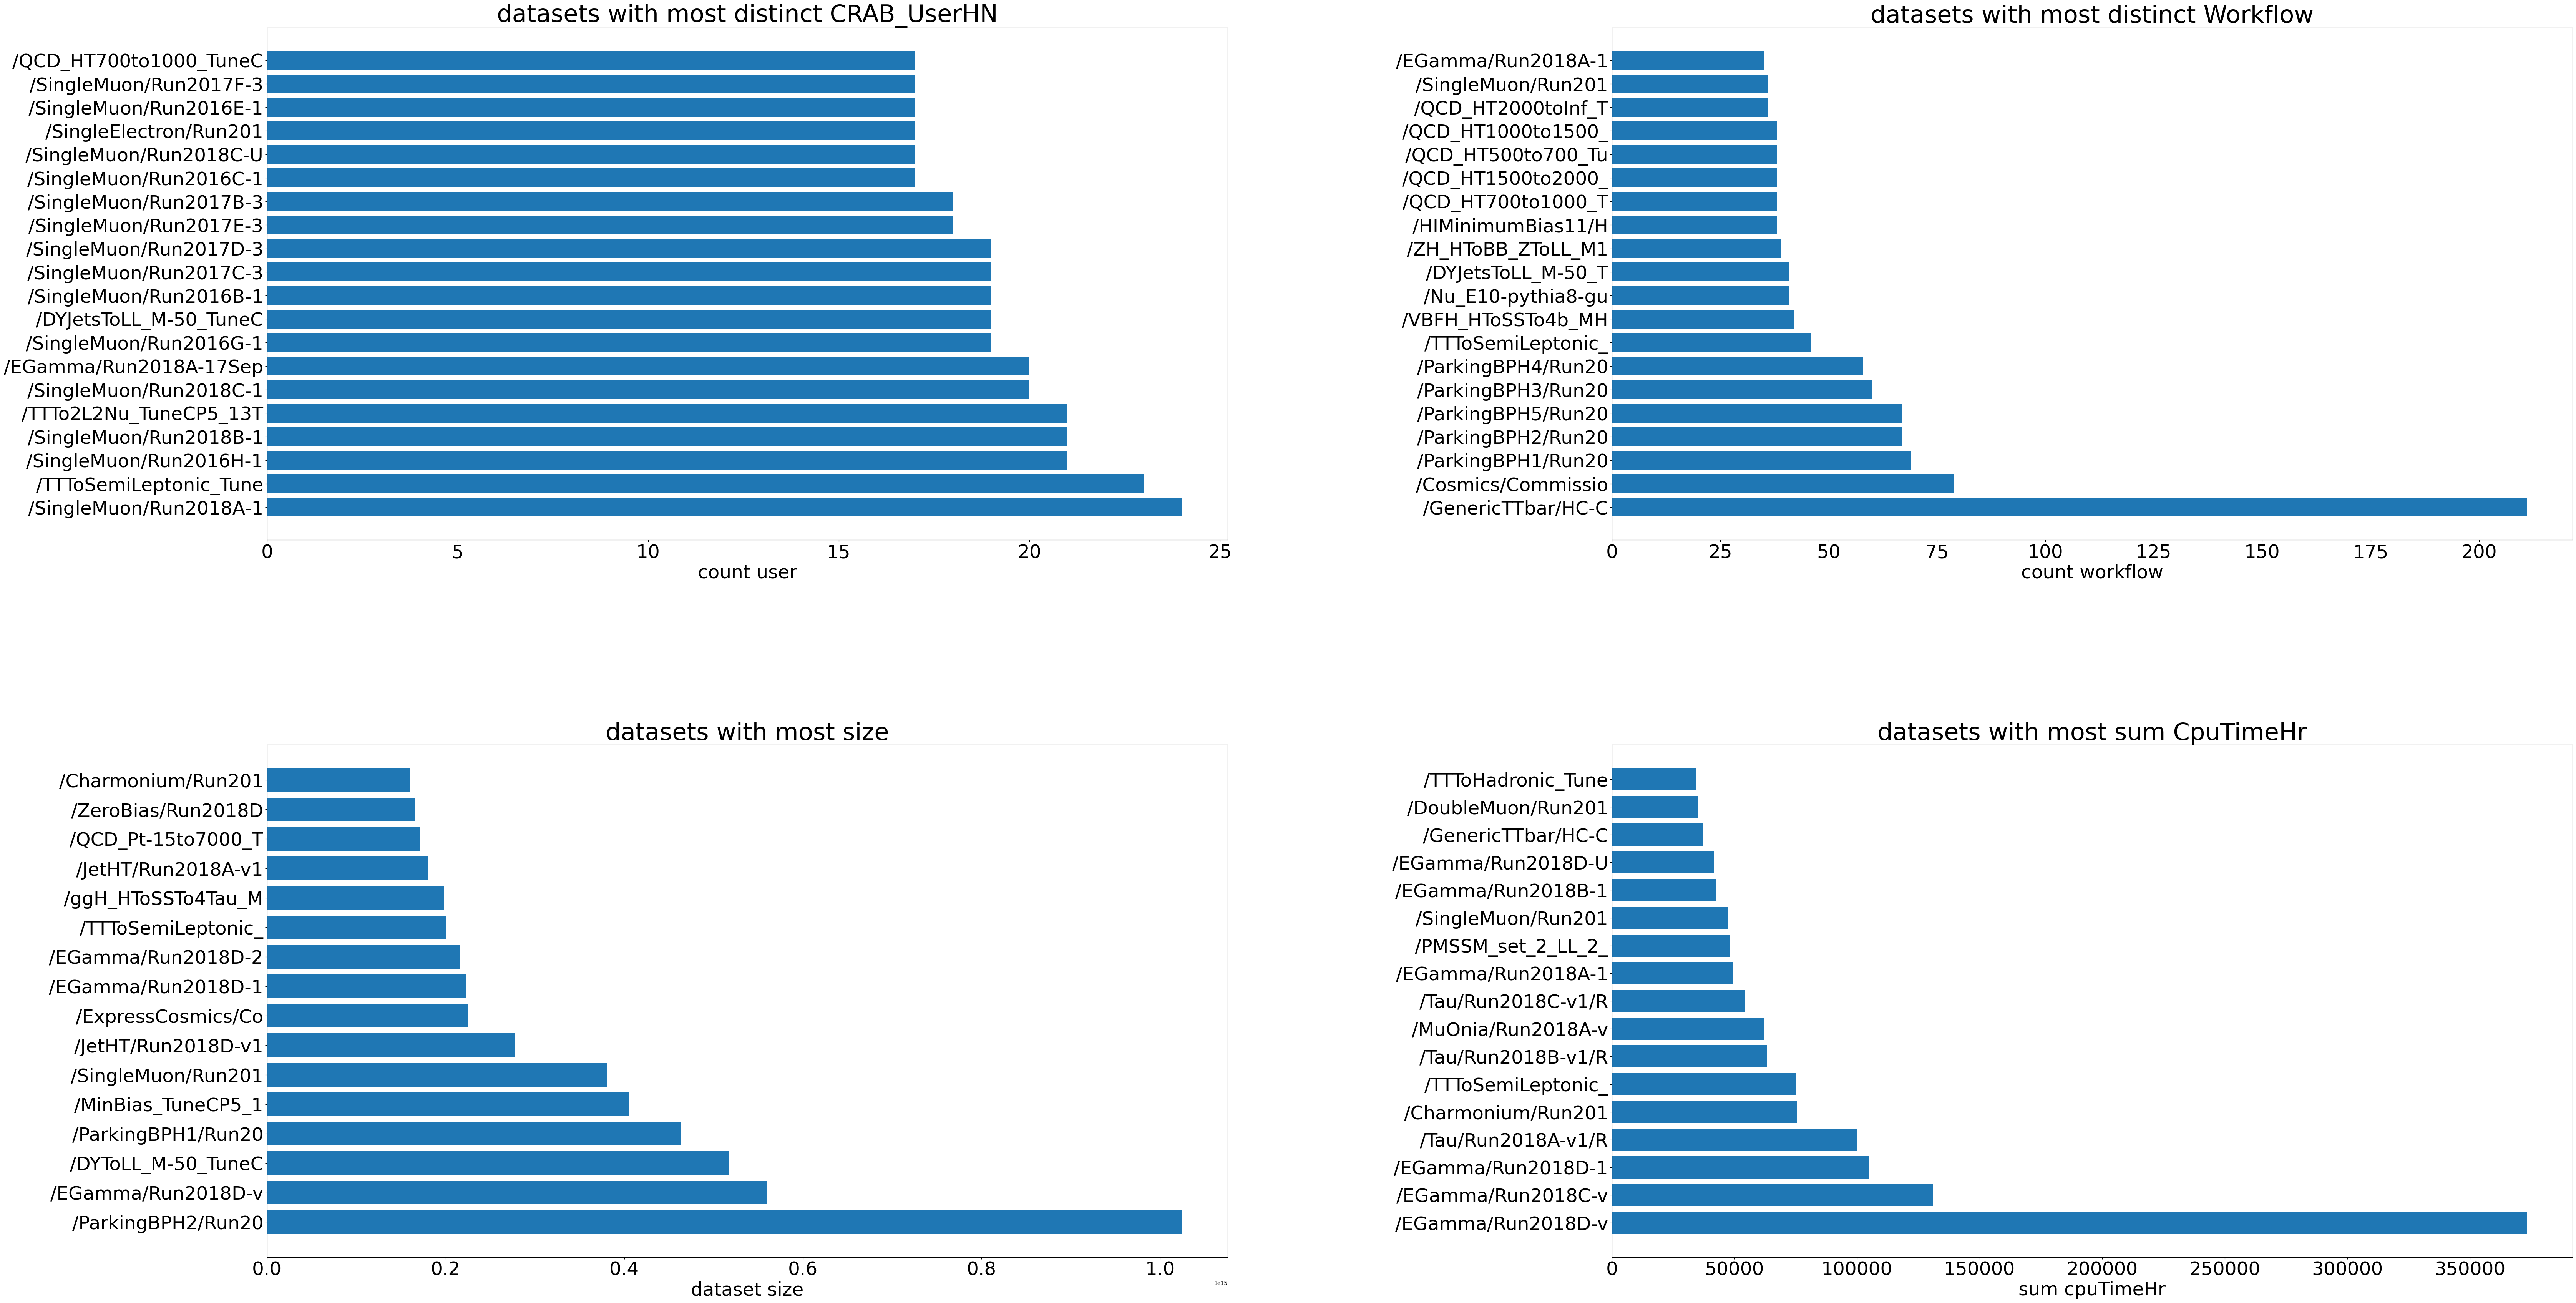

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(40, 40))

ax[0,0].barh([(i[0:22]) for i in dataset_CRAB_UserHN["DESIRED_CMSDataset"] ],list(dataset_CRAB_UserHN["distinct_CRAB_UserHN"]))
ax[0,0].set_title('datasets with most distinct CRAB_UserHN', fontsize=45)
ax[0,0].set_xlabel("count user", fontsize=35)
ax[0,0].tick_params("both", labelsize=35)

ax[0,1].barh([(i[0:18]) for i in dataset_Workflow["DESIRED_CMSDataset"] ],list(dataset_Workflow["distinct_Workflow"]))
ax[0,1].set_title('datasets with most distinct Workflow', fontsize=45)
ax[0,1].set_xlabel("count workflow", fontsize=35)
ax[0,1].tick_params("both", labelsize=35)

ax[1,0].barh([(i[0:18]) for i in dataset_size["DESIRED_CMSDataset"] ],list(dataset_size["sum_file_size"]))
ax[1,0].set_title('datasets with most size', fontsize=45)
ax[1,0].set_xlabel("dataset size", fontsize=35)
ax[1,0].tick_params("both", labelsize=35)

ax[1,1].barh([(i[0:18]) for i in dataset_sum_CpuTimeHr["DESIRED_CMSDataset"] ],list(dataset_sum_CpuTimeHr["sum_CpuTimeHr"]))
ax[1,1].set_title('datasets with most sum CpuTimeHr', fontsize=45)
ax[1,1].set_xlabel("sum cpuTimeHr", fontsize=35)
ax[1,1].tick_params("both", labelsize=35)

plt.subplots_adjust(left=0.5,
                        bottom=0.1, 
                        right=2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.savefig("dataset-analysis.png", bbox_inches='tight')
plt.show()
